In [1]:
import os, pickle
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from aix360.algorithms.protodash import ProtodashExplainer
# from lime.lime_tabular import LimeTabularExplainer
# from lime.submodular_pick import SubmodularPick
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
METRIC = "auc"
WEIGHTS = "uniform"

def get_knn_score(k, data, index, metric=METRIC, weights=WEIGHTS):
    X_train, y_train, X_valid, y_valid = data
    knc = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = knc.predict_proba(X_valid)
        probs = probs[:, 1] if probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = knc.score(X_valid, y_valid)
    return score

def get_ci(samples, confidence=0.95):
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)

def protorandom(X, m, r=0.2, rtype=0):
    mr = int(r * m)
    mp = m - mr
    if rtype == 0:
        np = int((1-r) * len(X))
        pindex = np.random.choice(range(len(X)), np, replace=False)
        protodash = ProtodashExplainer()
        _, index, _ = protodash.explain(X[pindex], X[pindex], m=m)
        index = pindex[index]
    else:
        protodash = ProtodashExplainer()
        _, index, _ = protodash.explain(X, X, m=mp)
        available = [i for i in range(len(X)) if i not in index]
        rindex = np.random.choice(available, mr, replace=False)
        index = index + rindex.tolist()
    return index


In [31]:
D = 10
name = 'emb10'
train_path = 'data/bm/embs/resn_train_{}.pkl'.format(name)
valid_path = 'data/bm/embs/resn_valid_{}.pkl'.format(name)
f_train, _, y_train, X_train = pickle.load(open(train_path, "rb"))
f_valid, _, y_valid, X_valid = pickle.load(open(valid_path, "rb"))
# data = X_train, y_train, X_valid, y_valid
data = X_train[0], y_train[0], X_valid[0], y_valid[0]

k_range = [3, 5, 7, 9]
m_range = list(range(10, 55, 5))
f_scores = []
for k in k_range:
    score = get_knn_score(k, data, list(range(len(data[0]))))
    f_scores.append(score)
f_scores = np.array(f_scores)
f_scores

array([1., 1., 1., 1.])

In [32]:
p_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in p_idss:
        protodash = ProtodashExplainer()
        _, index, _ = protodash.explain(X_train, X_train, m=m)
        # index = protorandom(X, m, rtype=0)
        p_idss[m] = index
# pickle.dump(p_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# p_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
p_scores = []
for k in k_range:
    for m in m_range:
        p_scores.append(get_knn_score(k, data, p_idss[m]))
p_scores = np.array(p_scores).reshape(len(k_range), len(m_range))

/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


In [33]:
n_trials = 100
r_scores = []
np.random.seed(42)
for k in k_range:
    for m in m_range:
        scores = []
        for i in range(n_trials):
            index = np.random.choice(range(len(X_train)), m, replace=False)
            scores.append(get_knn_score(k, data, index))
        r_scores.append((scores))
r_scores = np.array(r_scores).reshape(len(k_range), len(m_range), n_trials)
# pickle.dump(r_scores, open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "wb"))
# r_scores = pickle.load(open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "rb"))
r_means = r_scores.mean(axis=-1)
r_confs = np.array([get_ci(r_scores[k][m]) for m in range(len(m_range)) for k in range(len(k_range))])

Text(0.5, 0.98, 'D=10, AUC, KNN weights uniform')

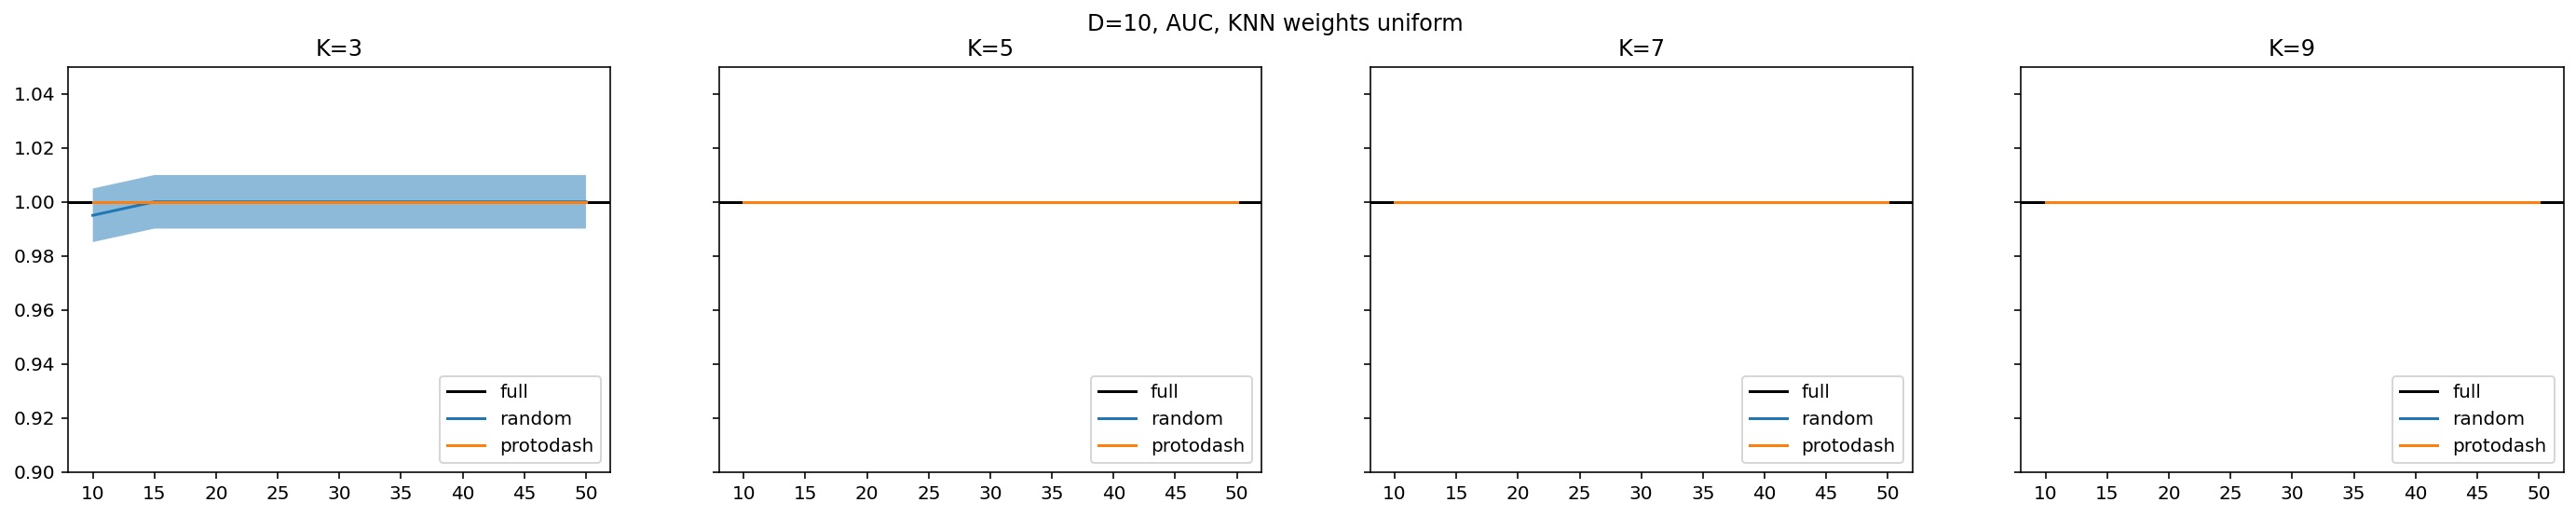

In [35]:
fig, ax = plt.subplots(1, len(k_range), figsize=(24, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_means[k])
    ax[k].fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores[k])
    # ax[k].plot(m_range, s_scores[k])
    ax[k].set_ylim(0.9, 1.05)
    ax[k].legend(['full', 'random', 'protodash'], loc='lower right')
    ax[k].set_title('K={}'.format(k_range[k]))
fig.suptitle('D={}, AUC, KNN weights '.format(D) + WEIGHTS)